In [1]:
#Imports and Setup

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import threading
import matplotlib.pyplot as plt
import datetime
from datetime import date

### Team Member Names: Daniel Kim, Kitty Cai, Andre Slavescu


In [2]:
# Reading in the stocks from the CSV file
stocks = pd.read_csv("Tickers.csv", header = None)
stocks.columns = ['ticker']

stocklist = stocks.ticker.tolist()

#Check if the ticker is a valid US listed stock
US_Tickers = []
def currency_checker(stockstr):
    stock = yf.Ticker(stockstr)
    if ('currency' in stock.info) and (stock.info['currency'] == 'USD') and (stock.info['market'] == 'us_market'):
        US_Tickers.append(stockstr)

# Threading:
threads = []

for i in range(len(stocklist)):
    stock = stocklist[i]
    t = threading.Thread(target = currency_checker, args = (stock,))
    threads.append(t)
    t.start()

for thread in threads:
    thread.join()


In [3]:
#Make sure calculations are only based on the time interval of of July 02, 2021 to October 22, 2021
start_date = '2021-07-02'
end_date = '2021-10-22'

#Making a list of stocks that is the list of valid stocks according to the guidelines in the Document
list_of_valid_stocks = []
threads = []

#Checks if the average daily volume of the stock is greater or equal to 10 000 shares
def volume_checker(stock_str):
    volume = yf.Ticker(stock_str).history(start = start_date, close = end_date).Volume.mean()
    if volume >= 10000:
        list_of_valid_stocks.append(stock_str)

#Checks for each stock in the stock list of US listed stocks
for i in range(len(US_Tickers)):
    stock = US_Tickers[i]
    t = threading.Thread(target = volume_checker, args = (stock,))
    threads.append(t)
    t.start()

for thread in threads:
    thread.join()

In [4]:
# Removes Duplicates
list_of_valid_stocks = list(dict.fromkeys(list_of_valid_stocks))

## Filtering Discussion:
Our portfolio's filtering process is based on the fact that we want to aim for a safe portfolio, which does not fluctuate too much. When there were more stocks in a portfolio, if one of the stocks rises or falls sharply, it does not move the portfolio as much. This is because the stock will only be a portion of the portfolio and if there are more stocks, an individual stock will make up an even smaller proportion of the portfolio. Since it is only a small proportion, when it fluctuates, it will not influence the entire portfolio. Thus, in order to prevent and minimize the risk of an individual stock, we decided to minimize the risk of our total portfolio by aiming for a portfolio of 20 stocks (the maximum allowed). By doing so, we are minimizing the risk that is related to an individual stock. In the case where there are less than 20 valid stocks after the filtering, they will all be taken into consideration so that we still have the maximum number of stocks in our portfolio. However risky stocks will be weighted less compared to the safer stocks within the portfolio (which will be explained later). Investing in as many stocks as possible allows the portfolio to be less susceptible to the risk of an individual stock. In addition, investing in many stocks gives higher chances of diversification. This could mean that our code will have higher chances of picking stocks from different industries (especially through the comparisons of correlations.)

## Create a Weighted Portfolio


We decided to use a point system to create our portfolio. Our portfolio is dependent on 4 factors: standard deviation, expected returns, beta, and correlation.


First we calculated the standard deviation of all of the valid stocks and ordered them from smallest standard deviation to largest. Then we give the smallest standard deviation the most points, 20 points. This is because we are aiming for a portfolio with the largest amount of stocks within the limit of 20 (if there are less than 20 valid stocks, then this logic will still apply but will only go up to the length of the list of valid stocks). From there, each following ticker will receive one less point and after the first twenty stocks (or maximum number of stocks that are valid), all other tickers will not receive any points.


Similarly, this was done for the expected returns and betas. The expected returns were listed from smallest to largest because we our hoping our portfolio will have nearly $0 of return after the period. The stock with the lowest expected returns received 20 points, the second lowest receiving 19 points, and so on.


We calculate how much each stock should minimally weigh and then calculate a second percentage of how much more we should make each stock weigh. This is done so to prevent an individual stock from weighing too much and making our portfolio too susceptible to the performance of that individual stock. This point system also ensures that there isn't too much of difference between the weightings because we do not want one stock to have too large of a proportion of the portfolio.


The fourth factor we considered is correlation however this was calculated differently from the other three factors. Correlation was calculated by comparing the correlation of the stock to the portfolio that we generated (this will be later elaborated on in the correlation section). We created an algorithm such that if the correlation of that individual stock and the portfolio is below 0.5, then the stock receives 10 points. 






## 1. Standard Deviation:
In order to create a portfolio that has low returns, one crucial factor to consider is the standard deviation of the stock. The formula for the standard deviation is given by:
\begin{align*}
\sigma_X=\sqrt{\frac{\sum(x_i-\overline{X})}{N}}
\end{align*}
In finance, standard deviation is a measure of the total risk associated with the expected return. Consequently, less risky stocks have lower standard deviation values compared to their riskier counterparts as the lower standard deviation value indicates that the security possesses a lower trading range and has fewer spikes in its prices. Since we are attempting to make a safe portfolio, we want to choose stocks that have low standard deviation values. By doing so, we are choosing stocks that have a lower trading range and makes the portfolio less susceptible to large-scale losses or gains. This follows the fundamental relationship in finance between risk and return. By minimizing our risk, we are decreasing the opportunity for our portfolio to undergo large changes in its value. Conversely, by adding in stocks that have low risk in their expected returns, thus low standard deviation, our portfolio will be safer and will thereby have less fluctuations in the value of our portfolio.

Consequently, in this section, we will be calculating the standard deviation of the returns of each of the stocks that are in the CSV file. Afterwards, we will be finding which stocks have the lowest standard deviation values, which indicates that they are the safest stocks. From these results, we will be assigning points to the stocks that have the lowest standard deviation values (with the stocks with the lowest standard deviation values earning the most points). 

In [5]:
#Return a dataframe with all of the valid stocks and their closing prices
stock_closing = pd.DataFrame()

for ticker in list_of_valid_stocks:
    #Get the ticker
    x = yf.Ticker(ticker)
    #Get ticker history
    y = x.history(start = start_date, end = end_date)
    #Return the closing price of the ticker during the period of time
    stock_closing[ticker] = y['Close']

stock_closing

,GOOG,PYPL,MON,BIIB,OXY,PM,SO,NKE,AMZN,ABT,...,BA,UPS,JPM,CVS,CAT,PFE,COP,TGT,MO,T
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-02,2574.379883,290.239990,9.655,348.720001,32.566921,99.076950,60.274460,159.476837,3510.979980,117.140038,...,236.679993,209.383667,155.095413,81.460457,215.408234,39.030785,61.901985,244.899979,46.675827,27.617552
2021-07-06,2595.419922,292.640015,9.730,344.890015,30.497753,97.447075,60.382214,159.846222,3675.739990,117.914093,...,236.139999,209.146103,152.491104,80.225159,211.214035,38.598530,59.465363,243.777664,45.831280,27.419138
2021-07-07,2601.550049,297.130005,9.730,355.329987,29.468164,97.585365,60.431190,159.896149,3696.580078,118.956093,...,231.779999,212.085968,152.670029,80.383278,212.371399,38.657471,58.212528,245.863373,45.949127,27.334101
2021-07-08,2583.540039,295.049988,9.749,369.049988,29.648092,97.170486,60.294048,160.365372,3731.409912,118.350739,...,236.770004,209.918198,150.035904,79.276459,209.819260,38.559231,58.409828,246.886353,45.595596,27.112812
2021-07-09,2591.489990,300.209991,9.663,358.160004,30.227859,98.187927,60.215683,160.734756,3719.340088,118.827072,...,239.589996,211.749420,154.836975,80.363518,215.071915,38.912895,59.317394,246.886353,46.548164,27.372587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-15,2833.500000,268.350006,9.750,281.190002,31.660000,98.370003,62.469162,158.009995,3409.020020,117.489998,...,217.039993,192.797455,166.610001,85.344101,197.927139,41.128979,73.697258,244.873398,48.700001,25.700001
2021-10-18,2859.209961,270.329987,9.780,269.730011,32.930000,97.449997,61.796280,159.429993,3446.739990,116.820000,...,216.979996,192.439224,166.550003,83.991959,197.091736,40.960457,74.055107,252.786346,48.130001,25.330000
2021-10-19,2876.439941,271.700012,9.780,268.130005,32.939999,95.790001,62.310837,157.820007,3444.149902,119.339996,...,215.970001,192.837250,168.570007,84.399590,200.035492,41.723755,74.870216,251.331329,47.900002,25.590000


In [6]:
# Getting the Daily Returns of each stock that is a valid stock.
returns = 100 * stock_closing.resample('D').first().pct_change()
returns = returns.iloc[1:]
returns.dropna(axis=1, how="all", inplace = True)
# Calculate the standard deviation and making a dataframe of the standard deviations of each of the stocks.
std = pd.DataFrame(returns.std())
std = std.reset_index()
std = std.rename(columns={"index": "Stocks", 0: "Standard Deviation"})
std.dropna(inplace = True)
# Sorting in increasing order of the standard deviations
std = std.sort_values(by = 'Standard Deviation')
std = std.reset_index(drop = True)
std.head()


,Stocks,Standard Deviation
0,MON,0.348784
1,PG,0.609159
2,KO,0.631825
3,SO,0.654017
4,PEP,0.655771


In [7]:
#Address points for standard deviation
#Loop through all indices in the condensed list and produce a point score for each stock
#A stock recieves more points for having a low standard deviation because this indicates that it did not fluctuate as much
#The goal of the portfolio is to be safe and have a return close to $0 as possible so stocks with low standard deviation will recieve more points
std_points = []
for i in range (len(std)):
    if i < 20:  
        std_points.append(20-i)              
    else:
        std_points.append(0)
#print(std_points)

In [8]:
# Initialize points column for standard deviation
std['PointsS'] = std_points
std.head()

,Stocks,Standard Deviation,PointsS
0,MON,0.348784,20
1,PG,0.609159,19
2,KO,0.631825,18
3,SO,0.654017,17
4,PEP,0.655771,16


## Standard Deviation:
In our final dataframe named std, we have arranged the stocks in a manner such that the stock with lowest standard deviation values, hence the least riskiest stock, is first and it increases in ascending order of standard deviation values. The first in our dataframe earned the most points as it is the safest and we would like to take this into consideration later on when we determine the weighting of the different stocks in our portfolio. 

To further solidfy the idea that stocks with lower standard deviations have smaller fluctuations in their returns and are thereby safer, we will plot a graph of the daily returns of the stock with the lowest standard deviation value and the stock with the highest standard deviation value and compare the graphs with one another and note important observations.

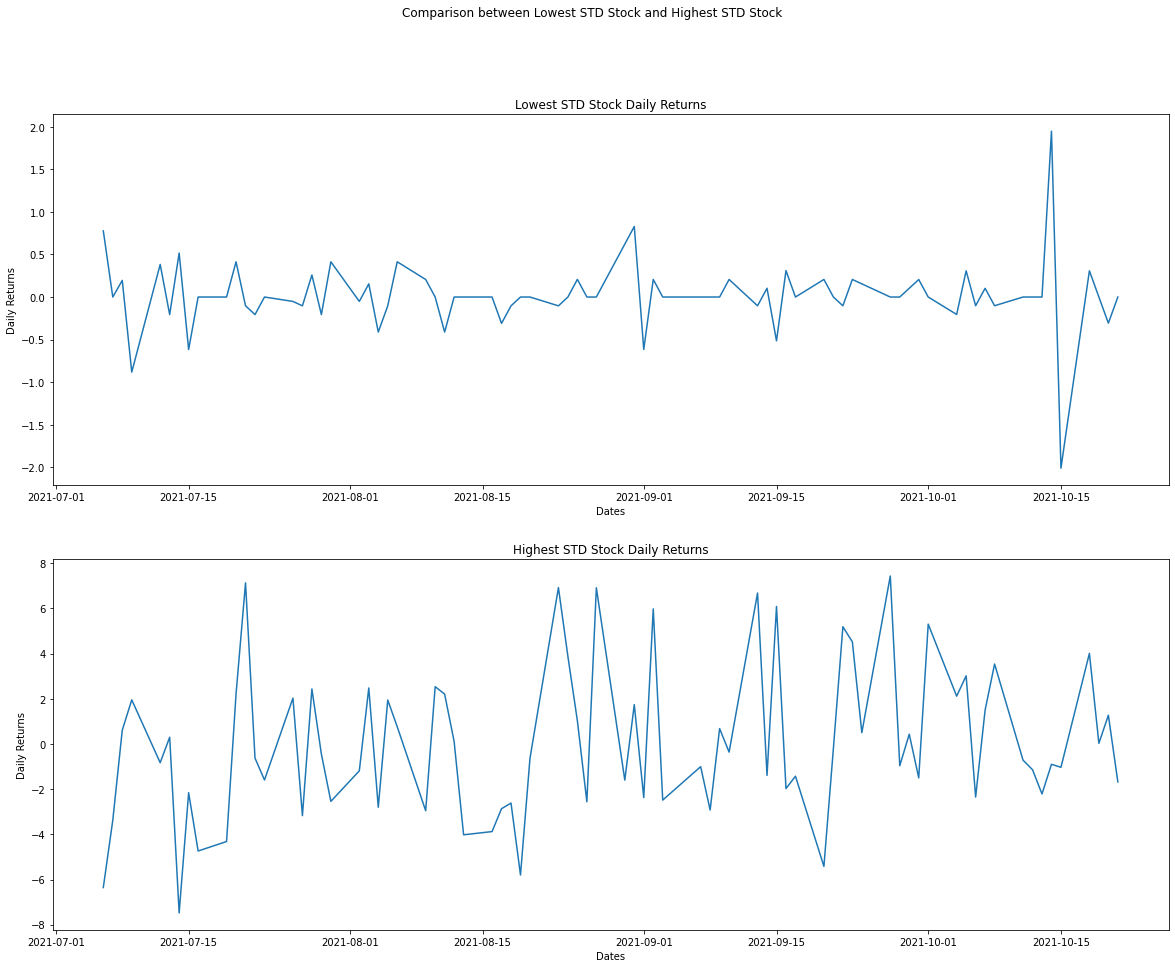

In [9]:
# Getting the two stocks:
lowest_std_stock = yf.Ticker(str(std["Stocks"].iloc[0]))
highest_std_stock = yf.Ticker(str(std["Stocks"].iloc[-1]))

# Getting their returns from the historical data
lowest_std_stock = yf.Ticker(str(std["Stocks"].iloc[0]))
highest_std_stock = yf.Ticker(str(std["Stocks"].iloc[-1]))
lowest_std_stock_hist_returns_df = pd.DataFrame(100 * lowest_std_stock.history(start = start_date, end = end_date).Close.pct_change().iloc[1:])
highest_std_stock_hist_returns_df = pd.DataFrame(100 * highest_std_stock.history(start = start_date, end = end_date).Close.pct_change().iloc[1:])

# For the subplot:
fig, ((ax1), (ax2)) = plt.subplots(2,1)
fig.set_size_inches(20, 15)

# Overall title
fig.suptitle('Comparison between Lowest STD Stock and Highest STD Stock')

# Subplot 1: The Price Weighted Index
ax1.plot(lowest_std_stock_hist_returns_df.index, lowest_std_stock_hist_returns_df.Close)
ax1.set_xlabel("Dates")
ax1.set_ylabel("Daily Returns")
ax1.title.set_text("Lowest STD Stock Daily Returns")

# Subplot 2: The Market Weighted Index
ax2.plot(highest_std_stock_hist_returns_df.index, highest_std_stock_hist_returns_df.Close)
ax2.set_xlabel("Dates")
ax2.set_ylabel("Daily Returns")
ax2.title.set_text("Highest STD Stock Daily Returns")

## Standard Deviation Discussion Cont'd:
As we can see from our two graphs, generally, the returns of the stock with the lower standard deviation have a smaller range and is generally much less volatile compared to its higher standard deviation counterpart. The stock with the highest standard deviation possesses much more spikes in its returns compared to the safer stock. From this graph, we can see that the stock with the lower STD can be seen as a safer stock as its returns fluctuate significantly less than that of a stock with a higher STD. Consequently, by assigning more points, and therefore greater weighting on stocks that have a lower standard deviation, we are effectively making our portfolio safer. In addition, notice that although the fluctuations seem wide, the changes of the daily returns for the safest stock only fluctuates between a smaller range, whereas the returns of the stock with the highest standard deviation actually fluctuates in a much larger range. 

In [10]:
%%latex
\newpage

<IPython.core.display.Latex object>

## 2. Expected Returns:
Another key factor to consider is the expected returns of each of the individual stocks. For our safe portfolio, we want the expected returns of our portfolio to be as close to 0 as possible. The expected returns of a portfolio can be calculated using the following formula:

\begin{align*}
E(X) Portfolio = (Security1_{Expected Return} \times Security1_{Weight}) + (Security2_{Expected Return} \times Security2_{Weight}) + ... + (Security n_{Expected Return} \times Security n_{Weight})
\end{align*}

Consequently, to have the lowest expected returns for the portfolio, we want the expected returns of each of the selected stocks to be as low as possible. Therefore, we will be attempting to find the expected returns of each of the stocks that are valid in our CSV file and then awarding points to the stocks that have the lowest expected returns are selected and have a higher weighting so that the expected return of our portfolio is as close to 0 as possible. 

In [11]:
#Get the expected returns
#We will be taking the absolute value as we want to consider the stock with the smallest expected return in magnitude
expected_returns = pd.DataFrame(100 * returns.mean().abs())
#Calculate the expected returns and plot it on dataframe
expected_returns.dropna(inplace = True)
expected_returns = expected_returns.reset_index()
expected_returns = expected_returns.rename(columns={"index": "Stocks", 0: "Expected Returns"})
#Sorted in increasing order of expected returns of each of the stocks
expected_returns = expected_returns.sort_values(by = "Expected Returns")
expected_returns = expected_returns.reset_index(drop = True)
expected_returns.head()

,Stocks,Expected Returns
0,SBUX,0.046989
1,GM,0.778134
2,MON,0.942456
3,LMT,1.049853
4,KO,1.157634


In [12]:
#Address points for the percent expected returns
#Loop through all indices in the condensed list and produce a point score for each stock
#A stock recieves more points for having a low expected return because this indicates that the stock is not very volatile
#The goal of the portfolio is to be safe and have a return close to $0 as possible so stocks with low expected returns will recieve more points
returns_points = []
for i in range (len(expected_returns)):
    if i < 20:
        returns_points.append(20-i)             
    else:
        returns_points.append(0)

In [13]:
#Initialize points column for returns 
expected_returns['PointsR'] = returns_points
expected_returns.head()

,Stocks,Expected Returns,PointsR
0,SBUX,0.046989,20
1,GM,0.778134,19
2,MON,0.942456,18
3,LMT,1.049853,17
4,KO,1.157634,16


## Expected Returns:
In our expected_returns dataframe, we have arranged the stocks in a manner such that the stock with the lowest expected returns is placed first in our dataframe and then the rest are sorted in increasing order of expected returns. 

In order to showcase how the expected returns of a portfolio will change, we will graph the expected returns of a portfolio with the first 5 stocks in our dataframe, otherwise the 5 stocks with the lowest expected returns, and we will also graph a portfolio with the last 5 stocks in our dataframe, otherwise the 5 stocks with the highest expected returns. We will be calling on functions that get the closing prices and make equally weighted portfolios. Then, we will be getting the expected returns of both of the portfolios and comparing the two.

**Note**: Please note that these generated portfolios are not entirely accurate nor ideal, as they will be made with each stock being weighted equally as an assumption. Consequently, these graphs are here to serve for general analysis to show the discrepancies between a portfolio that has stocks with high expected returns compared to a portfolio that has low expected returns. The assumed initial investment value will be $100,000. 

In [14]:
#Getting the first 5 and the last 5 stocks from our dataframe into a list. 
low_er_stocks = expected_returns["Stocks"].iloc[:5].tolist()
high_er_stocks = expected_returns["Stocks"].iloc[-5:].tolist()

In [15]:
#A function that produces a dataframe that displays all of the closing prices in a list of stocks
def get_closing_prices(list_of_stocks, start_date, end_date):
    stocks_close_df = pd.DataFrame()
    for i in range(len(list_of_stocks)): 
        stock = yf.Ticker(list_of_stocks[i])
        stock_historical = stock.history(start= start_date , end = end_date , threads=True)
        stocks_close_df[list_of_stocks[i]] = stock_historical["Close"]
        stocks_close_daily = stocks_close_df.resample("D").first()
        stocks_close_daily = stocks_close_daily.dropna()
    return stocks_close_daily
#For the low expected returns stocks:
low_er_close = get_closing_prices(low_er_stocks, start_date, end_date)
#For the high expected returns stocks:
high_er_close = get_closing_prices(high_er_stocks, start_date, end_date)

In [16]:
#  A function that consumes a list of stocks, and an initial investment size and a dataframe of closing prices of the list of stocks and produces a hypothetical portfolio where each stock is weighted the same. This hypothetical portfolio (which is not the final portfolio), will be used to calculate the correlation of each of the stocks to this hypothetical portfolio to see whether or not the stock in question has a low correlation with the rest of the stocks in the portfolio. 
def get_data(list_of_stocks,initial_investement, stock_close):
    number_of_stocks =[]
    dataframe = pd.DataFrame()
    # Here we are calculating the number of stocks that we will buy initially and their values. 
    for i in range(len(list_of_stocks)):
        number_of_stocks = (initial_investement/len(list_of_stocks))/stock_close.iloc[0, i]
        dataframe[list_of_stocks[i] + " value"] = stock_close[list_of_stocks[i]] * number_of_stocks

    returns = pd.DataFrame(index = stock_close.index)
    returns = pd.concat([returns, dataframe], join = "outer", axis = 1)
    # We are now summing all of the values of each stock to find the value of the total portfolio
    returns["Portfolio Value"]= returns.sum(axis=1)
    # To find the returns, we are finding the % change of the portfolio value. 
    returns["Returns"] = 100 * returns["Portfolio Value"].pct_change()
    return returns

# For the low expected returns portfolio:
low_er_portfolio = get_data(low_er_stocks, 100000, low_er_close)
# For the high expected returns portfolio:
high_er_portfolio = get_data(high_er_stocks, 100000, high_er_close)

In [17]:
# Making one dataframe to compare the two:
comparison = pd.DataFrame()
comparison["Low ER Portfolio Returns"] = low_er_portfolio["Returns"]
comparison["High ER Portfolio Returns"] = high_er_portfolio["Returns"]

# Printing the expected returns:
print('Expected Returns:')
print(comparison.mean())

Expected Returns:
Low ER Portfolio Returns     0.000153
High ER Portfolio Returns    0.139980
dtype: float64


## Expected Returns:
As we can see from our above code and calculations, the expected returns of the portfolio that has the stocks with high expected returns, is significantly higher than the expected returns of the portfolio that is composed of stocks with low expected returns. Consequently, from this result and this generalized example, we can see that choosing stocks with low expected returns will also result in the expected returns of the portfolio to be lower compared to that of choosing stocks that have high expected returns. Ultimately, this demonstrates why stocks with lower expected returns were given more points as we want the stocks with lower expected returns to be weighted higher so that the expected returns of our final portfolio are lower.

In [18]:
%%latex
\newpage

<IPython.core.display.Latex object>

## 3. Beta:
Since we are attempting to build a safe portfolio, and thus minimize risk, we can use another measure of risk known as beta to further reaffirm that we are choosing the least risky stocks. Beta is a measure of the risk of a single stock relative to the entire market. The higher the beta value, the riskier the stock. Beta will tell us how the stock is moving relative to the movement of the market. For instance, if a stock has a beta of 1.5, then this means that the returns of this stock are 1.5 times more volatile than the returns of the market. Consequently, if we are able to find stocks that have beta values that are close to 0, this means that the stock would be generally safer and would also indicate that the stock's movement is uncorrelated with the market. These stocks will generally be less volatile compared to high beta stocks, therefore, we are minimizing the risk by choosing the stocks with a low beta value. 

Consequently, we will be attempting to find stocks with a beta value close to 0.

In [19]:
# Getting a list of all of the stocks
list_of_all_stocks = returns.columns.values.tolist()

In [1]:
# Making a dataframe of the market index
market_index = pd.DataFrame()
# '^GSPC is the ticker of the S&P 500, this will be used as a general market index 
MarketIndex = '^GSPC'
MarketIndex_hist = yf.Ticker(MarketIndex).history(start=start_date, end=end_date)
market_index[MarketIndex] = 100 * MarketIndex_hist['Close'].resample('D').ffill().pct_change()
market_index = market_index.iloc[1:]
# Calculating the variance of the market
MarketVar= market_index[MarketIndex].var()

# Creating a dataframe with all of the Betas of each of the stock relative to the market
df = pd.DataFrame()
for i in range(len(list_of_all_stocks)):
    stock_hist = yf.Ticker(list_of_all_stocks[i]).history(start=start_date, end=end_date)
    stock_returns = pd.DataFrame()
    stock_returns[list_of_all_stocks[i] + " Returns"] = 100 * stock_hist['Close'].resample('D').ffill().pct_change()
    stock_returns = stock_returns.iloc[1:]
    stock_returnsb = pd.concat([stock_returns, market_index], join='inner', axis=1)
    # Calculating Beta
    # Note that we will be taking the absolute value of the beta values. Although beta can technically be negative, we are attempting to find the stocks that have a beta value that is closest to 0 and so taking the absolute value of the beta value will allows to find these stocks that have a beta value closest to 0. 
    Beta= abs(stock_returnsb.cov()/MarketVar)
    df.loc[0, list_of_all_stocks[i]] = Beta.iat[0,1]

df

NameError: name 'pd' is not defined

In [21]:
# calculate beta value for each stock in the condensed list
beta = df.T
beta = beta.reset_index()
beta = beta.rename(columns={"index": "Stocks", 0: "Beta"})
beta.dropna(inplace = True)
# Sorting all of them in increasing order of Beta Values
beta = beta.sort_values(by = 'Beta')
beta = beta.reset_index(drop = True)
beta.head()

,Stocks,Beta
0,MON,0.027794
1,PG,0.275025
2,SO,0.297969
3,CL,0.345618
4,PEP,0.366149


In [22]:
#Assign points for each stock's beta value
#Loop through all indices in the condensed list and produce a point score for each stock
#A stock recieves more points for having a beta close to zero is less risky and offers low returns
#The goal of the portfolio is to be safe and have a return close to $0 as possible so stocks with low betas will recieve more points
beta_points = []
for i in range (len(beta)):
    if i < 20:
        beta_points.append(20-i)              
    else:
        beta_points.append(0)
#returns_points

In [23]:
# Initialize a points column for beta values
beta['PointsB'] = beta_points
beta.head()

,Stocks,Beta,PointsB
0,MON,0.027794,20
1,PG,0.275025,19
2,SO,0.297969,18
3,CL,0.345618,17
4,PEP,0.366149,16


## Beta Discussion:
Using the code above, we were able to find the beta of each individual stock and award points to the stocks that have the lowest beta values. Similar to our analysis for the standard deviation, we can compare the returns between the stock with the lowest beta value and the stock with the highest beta value as well as the returns of the market to showcase how the stock with the lowest beta will also yield the lowest expected returns and why we chose stocks with low beta values.

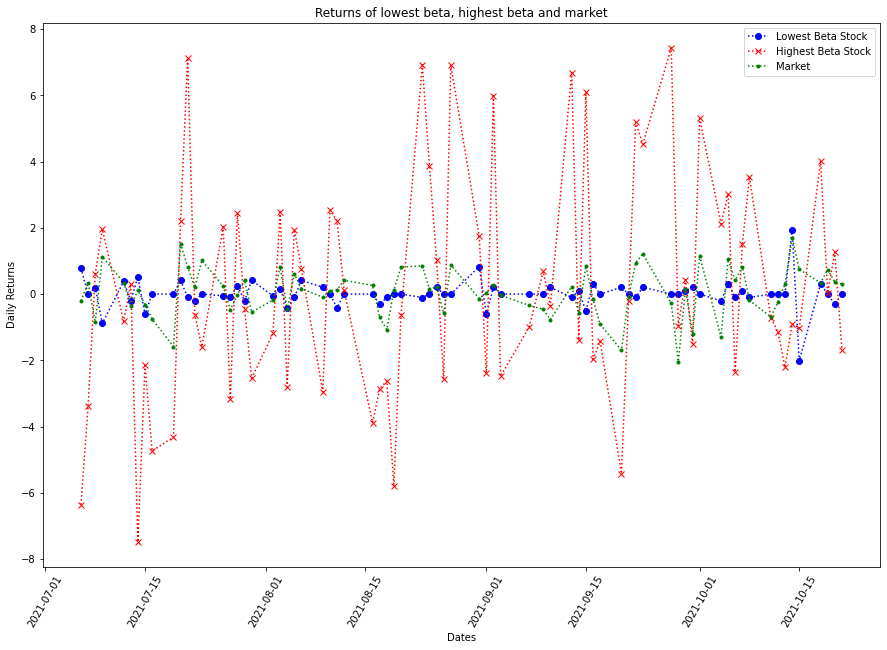

In [24]:
# Getting the two stocks:
lowest_beta_stock = yf.Ticker(str(beta["Stocks"].iloc[0]))
highest_beta_stock = yf.Ticker(str(beta["Stocks"].iloc[-1]))

# Getting their returns from the historical data
lowest_beta_stock_df = pd.DataFrame(100 * lowest_beta_stock.history(start = start_date, end = end_date).Close.pct_change().iloc[1:])
highest_beta_stock_df = pd.DataFrame(100 * highest_beta_stock.history(start = start_date, end = end_date).Close.pct_change().iloc[1:])
highest_beta_stock_df["Highest Beta Returns"] = highest_beta_stock_df["Close"]
highest_beta_stock_df = highest_beta_stock_df.drop(columns = ['Close'])
combined_beta_df = pd.concat([lowest_beta_stock_df, highest_beta_stock_df, market_index], join = "inner", axis = 1)

plt.figure(figsize=(15,10))
# Plot line for lowest_beta_stock
plt.plot(combined_beta_df.index, combined_beta_df["Close"], label = 'Lowest Beta Stock' , marker='o', ls=':', color='b')
# Plot line for highest_beta_stock
plt.plot(combined_beta_df.index, combined_beta_df["Highest Beta Returns"] ,label = 'Highest Beta Stock', marker = 'x',  ls=':', color='r')
# Plot line for market
plt.plot(combined_beta_df.index, combined_beta_df["^GSPC"] ,label = 'Market', marker = '.',  ls=':', color='g')


# Title 
plt.title('Returns of lowest beta, highest beta and market')
# Add axes labels
plt.xlabel('Dates')
plt.xticks(rotation= 60)
plt.ylabel('Daily Returns')
plt.legend(loc = 'best')

plt.show()

## Beta Discussion Cont'd:
From the graph, we can see that, generally, the returns of the stock with the highest beta had more volatile returns than that of the lower beta stock. While this is not always the case, this is generally true which is further backed by the beta calculations we did in the code. Since the returns of lower beta stocks have, generally (not always as there are instances when this is not true), lower volatility than their higher beta stocks, then this indicates that lower beta stocks are a better fit for our safe portfolio. While low beta stocks can still be risky, they are simply less volatile which justifies our allocation of points for this factor. 

In [25]:
%%latex
\newpage

<IPython.core.display.Latex object>

## Sorting the Stocks by their Points:
In this section, we will be compiling all of the stocks into one large dataframe in order of their points. In each section, we will be sorting the stocks in alphabetical order so that each of the separate dataframes can then be merged together. Then, we shall combine all of the different stocks and their associated point values for each of the factors listed above and then all of the points of each factor for each stock will be summed together to find the total points that each stock earned. 

In [26]:
std = std.reset_index(drop = True)
#Sort stocks in order alphabetical order in preparations to add the points together
std = std.reset_index(drop = True)
std = std.sort_values(by = 'Stocks')
std = std.reset_index(drop = True)
std.head()

,Stocks,Standard Deviation,PointsS
0,AAPL,1.053117,0
1,ABBV,1.036335,0
2,ABT,0.817759,11
3,ACN,0.828390,10
4,AIG,1.525788,0


In [27]:
expected_returns = expected_returns.reset_index(drop = True)
#Sort stocks in order alphabetical order in preparations to add the points together
expected_returns = expected_returns.sort_values(by = 'Stocks')
expected_returns = expected_returns.reset_index(drop = True)
expected_returns.head()

,Stocks,Expected Returns,PointsR
0,AAPL,6.480651,0
1,ABBV,2.529781,10
2,ABT,6.219498,0
3,ACN,12.569653,0
4,AIG,20.586843,0


In [28]:
beta = beta.reset_index(drop = True)
#Sort stocks in order alphabetical order in preparations to add the points together
beta = beta.sort_values(by = 'Stocks')
beta = beta.reset_index(drop = True)
beta.head()

,Stocks,Beta,PointsB
0,AAPL,1.327051,0
1,ABBV,0.679155,4
2,ABT,0.468943,12
3,ACN,1.031590,0
4,AIG,1.460985,0


In [29]:
#Initialize dataframe with all point scores
pointsystem = pd.DataFrame()
# We will be adding columns to the dataframe with all of the points from each of the different sections. 
pointsystem['Stocks'] = beta['Stocks']
pointsystem['PointsS'] = std['PointsS']
pointsystem['PointsR'] = expected_returns['PointsR']
pointsystem['PointsB'] = beta['PointsB']
# Summing the points to get the total points.
pointsystem['TotalPoints'] = pointsystem['PointsS'] + pointsystem['PointsR'] + pointsystem['PointsB']
pointsystem.head()

,Stocks,PointsS,PointsR,PointsB,TotalPoints
0,AAPL,0,0,0,0
1,ABBV,0,10,4,14
2,ABT,11,0,12,23
3,ACN,10,0,0,10
4,AIG,0,0,0,0


In [30]:
pointsystem = pointsystem.reset_index(drop = True)
#Sort all point columns in order from greatest to least value
pointsystem = pointsystem.sort_values(by = 'TotalPoints', ascending = False)
pointsystem = pointsystem.reset_index(drop = True)
pointsystem.head()

,Stocks,PointsS,PointsR,PointsB,TotalPoints
0,MON,20,18,20,58
1,PG,19,6,19,44
2,KO,18,16,10,44
3,LMT,14,17,9,40
4,SO,17,0,18,35


## Choosing the stocks for the Portfolio:
After finding the total points of each of the stocks in our list of stocks, we must then use the point system to choose the maximum number of stocks, up to a maximum number of 20, that we wish to make up our portfolio and then also use these points to determine the weight of each stock in our portfolio. Thus, we will choose the top 20 (or if there are less than 20 valid stocks then the number of valid of stocks) stocks that have the highest point totals and these will be the stocks that will make up our portfolio.

In [31]:
#Only take the top 20 valid stocks to make a portfolio
pointsystem = pointsystem[:20] # same as df.head(20)
#Return the portfolio of 20 stocks
pointsystem.head()

,Stocks,PointsS,PointsR,PointsB,TotalPoints
0,MON,20,18,20,58
1,PG,19,6,19,44
2,KO,18,16,10,44
3,LMT,14,17,9,40
4,SO,17,0,18,35


In [32]:
#Make list of stocks that will be in our portfolio.
portfoliostocks = pointsystem["Stocks"].values.tolist()
print(portfoliostocks)

['MON', 'PG', 'KO', 'LMT', 'SO', 'PEP', 'CL', 'SBUX', 'ABT', 'PM', 'NEE', 'T', 'BMY', 'GM', 'AMZN', 'BIIB', 'MRK', 'ABBV', 'C', 'NKE']


## 4. Correlation:
One final factor to be considered is the correlation of the stocks with the rest of the stocks in our portfolio. Correaltion is a measure of how securities move in relation to one another. Since we want our portfolio to be safe and have lower returns, one method to minimize the expected returns of the portfolio would be to place greater weighting on stocks that have a negative correlation with the rest of the portfolio. For instance, if a stock exhibits a negative correlation with a portfolio that contains the rest of the stocks, then this indicates that when the overall returns of the portfolio goes up, then the returns of that portfolio goes down. When the correlations between a stock and the portfolio of stocks is relatively low, then placing greater weighting on these stocks will minimize the risk of the overall portfolio. By increasing the weighting on stocks (by allocating points) that have a relatively low correlation with the portfolio of 20 stocks that we have chosen, then when the portfolio increases or decreases in value, then the low or negatively correlated stock will either move in the opposite direction of the portfolio or will only move slightly in the same direction with the rest of the portfolio. 

In this section, we will be calculating the correlation of each of the stocks with the portfolio that contains the stocks that we have chosen using the point system before. The reasoning behind why we are doing the correlation after choosing the stocks in our portfolio is because we are only interested in weighing the stocks that have a low correlation with the rest of the stocks we have chosen. Generally, in statistics, stocks that have a correlation value between 0.3-0.5 is considered to be a low correlation (https://www.researchgate.net/post/What-are-the-correlation-values-with-respect-to-low-moderate-high-correlation-specially-in-medical-research#:~:text=Correlation%20coefficients%20whose%20magnitude%20are%20between%200.3%20and%200.5%20indicate,if%20any%20(linear)%20correlation.) . Consequently, for each stock in our portfolio that has a correlation value less than 0.5 with our portfolio will be assigned a flat number of 10 points.


In [33]:
# This is the dataframe with all of the closing prices of our list of stocks
closing_portfolio = get_closing_prices(portfoliostocks, start_date, end_date)
comparison_portfolio = get_data(portfoliostocks, 100000, closing_portfolio).iloc[1:]
comparison_portfolio = comparison_portfolio["Returns"]
# Initializes the dataframe with the columns we want. 
correlations_df = pd.DataFrame({'Stock': [], "Correlation" : [], "PointsC": []})

# This for loop will calculate the correlation of each stock with the portfolio that contains all of the stocks. If the correlation value of the stock is less than 0.5, then it will append it to the dataframe known as correlations_df. 
for i in range(len(portfoliostocks)):
    stocks_close_df = pd.DataFrame()
    stock = yf.Ticker(portfoliostocks[i])
    stock_historical = stock.history(start= start_date , end = end_date , threads=True)
    stocks_close_df[portfoliostocks[i]] = stock_historical["Close"]
    stocks_close_returns = stocks_close_df.resample("D").first().pct_change().iloc[1:]
    portfolio = pd.concat([comparison_portfolio, stocks_close_returns], join = "outer", axis = 1)
    correlation = portfolio.corr().iat[0,1]
    stock_name = portfoliostocks[i]
    if correlation < 0.5:
        
        stock_data = pd.DataFrame({'Stock': [stock_name],
                                   'Correlation': [correlation],
                                   'PointsC': [10]})
        correlations_df = correlations_df.append(stock_data)
    else:
        stock_data = pd.DataFrame({'Stock': [stock_name],
                                   'Correlation': [correlation],
                                   'PointsC': [0]})
        correlations_df = correlations_df.append(stock_data)
# Resetting the index after appending
correlations_df = correlations_df.reset_index()
# Creating a new dataframe that simply drops an invalid column
correlations_final = correlations_df.drop(columns = ['index'])
correlations_final = correlations_final.sort_values(by = ["Stock"], ascending = True)
correlations_final = correlations_final.reset_index(drop = True)
correlations_final

,Stock,Correlation,PointsC
0,ABBV,0.559104,0.0
1,ABT,0.516033,0.0
2,AMZN,0.396055,10.0
3,BIIB,0.333315,10.0
4,BMY,0.627438,0.0
5,C,0.476367,10.0
6,CL,0.597126,0.0
7,GM,0.400098,10.0
8,KO,0.726626,0.0
9,LMT,0.484656,10.0


## Correlation Discussion:
Using the code above, we were able to find all of the stocks in our portfolio that have a correlation value of less than 0.5 with our portfolio. We then awarded points to all of these stocks that have these lower correlation values so that when we use these points to weigh the stocks, the stocks that have a lower correlation value will have a greater weighting. 

## Recalculating the Points with the Correlation Points Now Added

We will now be readding all of the points together for our final point tallies and then using these point values to determine our weightings.

In [34]:
# We can resort and and now add the correlation points by dropping the total points column, adding in the correlation points column and then readding in the total points columns after summing all of the points.
pointsystem = pointsystem.sort_values(by = 
                            ["Stocks"],
                            ascending = True)
pointsystem = pointsystem.reset_index(drop = True)
pointsystem = pointsystem.drop(columns = ['TotalPoints'])
# Adding in the points
pointsystem["PointsC"] = correlations_final["PointsC"]
pointsystem['TotalPoints'] = pointsystem['PointsS'] + pointsystem['PointsR'] + pointsystem['PointsB'] + pointsystem["PointsC"]
pointsystem = pointsystem.sort_values(by = ["TotalPoints"],ascending = False)
pointsystem = pointsystem.reset_index(drop = True)
pointsystem


,Stocks,PointsS,PointsR,PointsB,PointsC,TotalPoints
0,MON,20,18,20,10.0,68.0
1,PG,19,6,19,10.0,54.0
2,LMT,14,17,9,10.0,50.0
3,KO,18,16,10,0.0,44.0
4,SO,17,0,18,0.0,35.0
5,PEP,16,0,16,0.0,32.0
6,CL,13,0,17,0.0,30.0
7,NEE,6,0,14,10.0,30.0
8,GM,0,19,0,10.0,29.0
9,BIIB,0,0,15,10.0,25.0


## Calculating the Weightings
In order to calculate the weightings, we will first start by assigning a miniumum base weighting of each stock, which is 100/(2n), where n is the number of stocks in our portfolio. After assigning the minimum base weightings, we will then find the total sum of the total points. We will the find the % of the points of each of the stocks and relative to the total sum of the total points. This will be our additional weightings and will be added onto the base weightings of each of the stocks. These will be the weighting of our stocks within our portfolio.

In [35]:
#Calculate total points for weighting metrics
total_points = pointsystem["TotalPoints"].sum(axis=0)
total_points

613.0

In [36]:
#Initialize a dataframe for calculating weights
base_weighting = pd.DataFrame()

#Initialize all instances with the same weighting value (minimum 2.5%)
for i in range(len(portfoliostocks)):
    base_weighting.loc[0, portfoliostocks[i]] = 100/(2 * (len(portfoliostocks)))

base_weighting = base_weighting.T
base_weighting = base_weighting.rename(columns={"index": "stocks", 0: "Weighting"})
base_weighting

,Weighting
MON,2.5
PG,2.5
KO,2.5
LMT,2.5
SO,2.5
PEP,2.5
CL,2.5
SBUX,2.5
ABT,2.5
PM,2.5


In [37]:
#Target weight value vs. weight acheived 
total_weight = 100
total_already_weighted = base_weighting["Weighting"].sum(axis=0)
total_already_weighted

50.0

In [38]:
#Weight to be manipulated to achieve 100% weighting 
manipulate_weight = total_weight - total_already_weighted
manipulate_weight

50.0

In [39]:
#Initialize list for remaining 50% weightage
further_weights = []
for i in range (len(pointsystem)):
    #Points for the stock if it were out of 100
    out_of_100 = pointsystem.iloc[i, 5]/total_points * 100
    # Stock weighting to be added per stock
    point_total = out_of_100 * manipulate_weight/total_weight
    further_weights.append(point_total)
print(f"Remaining weight distribution:\n{further_weights}")

Remaining weight distribution:
[5.5464926590538335, 4.404567699836868, 4.078303425774878, 3.588907014681892, 2.8548123980424145, 2.6101141924959217, 2.4469820554649266, 2.4469820554649266, 2.365415986949429, 2.039151712887439, 2.039151712887439, 1.957585644371941, 1.957585644371941, 1.957585644371941, 1.8760195758564437, 1.794453507340946, 1.7128874388254487, 1.631321370309951, 1.5497553017944536, 1.1419249592169658]


In [40]:
#Initialize dataframe column with the remaining 50% for the portfolio
base_weighting["MoreWeight"] = further_weights
base_weighting

,Weighting,MoreWeight
MON,2.5,5.546493
PG,2.5,4.404568
KO,2.5,4.078303
LMT,2.5,3.588907
SO,2.5,2.854812
PEP,2.5,2.610114
CL,2.5,2.446982
SBUX,2.5,2.446982
ABT,2.5,2.365416
PM,2.5,2.039152


In [41]:
#Initialize dataframe column with total weightage
base_weighting = base_weighting.reset_index()
base_weighting["TotalWeight"] = base_weighting["Weighting"] + base_weighting["MoreWeight"]
base_weighting.head()

,index,Weighting,MoreWeight,TotalWeight
0,MON,2.5,5.546493,8.046493
1,PG,2.5,4.404568,6.904568
2,KO,2.5,4.078303,6.578303
3,LMT,2.5,3.588907,6.088907
4,SO,2.5,2.854812,5.354812


In [42]:
#Check if the portfolio weight is correct
portfolio_weight_check = base_weighting["TotalWeight"].sum(axis=0)
print("The total weighting of our portfolio is " + str(portfolio_weight_check))

The total weighting of our portfolio is 99.99999999999999


In [43]:
#Use the datetime feature to get the current date

today = date.today()
#Convert the date into a usable string for getting tickers
now = today.strftime("20%y-%m-%d")
now


'2021-11-26'

In [44]:
todaym = datetime.date.today()
week_ago = today - datetime.timedelta(days = 7)
#Get the date from a week ago
previous = week_ago.strftime("20%y-%m-%d")
previous


'2021-11-19'

In [45]:
#Generate a portfolio with the closing prices from a week before today to today, the reason this was done is so that if there is invalid data for
#today or something does not display properly, the code will automatically take the last row of the dataframe
#The last row of the dataframe will contain the most up to date closing prices
portfolioclose = pd.DataFrame()

for ticker in portfoliostocks:
    x = yf.Ticker(ticker)
    
    y = x.history(start = week_ago, end = now)
    
    portfolioclose[ticker] = y['Close']

portfolioclose.tail()


,MON,PG,KO,LMT,SO,PEP,CL,SBUX,ABT,PM,NEE,T,BMY,GM,AMZN,BIIB,MRK,ABBV,C,NKE
Date,,,,,,,,,,,,,,,,,,,,
2021-11-19,9.76,146.820007,55.130001,341.440002,62.669998,163.809998,77.199997,110.779999,126.839996,90.400002,87.920593,24.129999,57.830002,61.799999,3676.570068,257.190002,80.699997,116.239998,66.339996,174.880005
2021-11-22,9.75,147.800003,55.470001,344.980011,63.119999,164.149994,77.559998,111.449997,125.260002,89.779999,86.974785,24.700001,57.040001,64.059998,3572.570068,252.210007,81.639999,115.650002,67.040001,174.240005
2021-11-23,9.81,149.440002,55.880001,345.179993,63.009998,165.250000,77.930000,113.580002,124.480003,89.650002,86.925003,24.760000,57.450001,63.049999,3580.040039,254.149994,82.800003,118.879997,68.070000,172.149994
2021-11-24,9.81,148.660004,55.430000,343.579987,63.099998,163.740005,77.760002,113.970001,125.070000,90.029999,87.209999,24.469999,56.810001,62.189999,3580.409912,250.130005,82.279999,118.660004,67.279999,172.029999


In [46]:
#Get the last row of the dataframe
buildclose = portfolioclose.iloc[[-1]]

buildclose = buildclose.reset_index(drop = True)
buildclose = buildclose.transpose()
buildclose = buildclose.reset_index()
buildclose.head()

,index,0
0,MON,9.810000
1,PG,148.660004
2,KO,55.430000
3,LMT,343.579987
4,SO,63.099998


In [47]:
#Merge the total weight with the closing price, sorry about the closing price column having a column name of 0
portfolioc = base_weighting.merge(buildclose)
portfolioc = portfolioc.rename(columns={'index': 'Ticker', 'Weighting': 'Weighting', "MoreWeight" : "MoreWeight", "TotalWeight" : "TotalWeight", 0 : "ClosingPrice"})
portfolioc

,Ticker,Weighting,MoreWeight,TotalWeight,ClosingPrice
0,MON,2.5,5.546493,8.046493,9.810000
1,PG,2.5,4.404568,6.904568,148.660004
2,KO,2.5,4.078303,6.578303,55.430000
3,LMT,2.5,3.588907,6.088907,343.579987
4,SO,2.5,2.854812,5.354812,63.099998
5,PEP,2.5,2.610114,5.110114,163.740005
6,CL,2.5,2.446982,4.946982,77.760002
7,SBUX,2.5,2.446982,4.946982,113.970001
8,ABT,2.5,2.365416,4.865416,125.070000
9,PM,2.5,2.039152,4.539152,90.029999


In [48]:
#Calculate how much money will be invested into each stock based on the weight
portfoliomoney = 100000
portfolioc['Invest'] = portfoliomoney * portfolioc['TotalWeight']/100
portfolioc

,Ticker,Weighting,MoreWeight,TotalWeight,ClosingPrice,Invest
0,MON,2.5,5.546493,8.046493,9.810000,8046.492659
1,PG,2.5,4.404568,6.904568,148.660004,6904.567700
2,KO,2.5,4.078303,6.578303,55.430000,6578.303426
3,LMT,2.5,3.588907,6.088907,343.579987,6088.907015
4,SO,2.5,2.854812,5.354812,63.099998,5354.812398
5,PEP,2.5,2.610114,5.110114,163.740005,5110.114192
6,CL,2.5,2.446982,4.946982,77.760002,4946.982055
7,SBUX,2.5,2.446982,4.946982,113.970001,4946.982055
8,ABT,2.5,2.365416,4.865416,125.070000,4865.415987
9,PM,2.5,2.039152,4.539152,90.029999,4539.151713


In [49]:
#Calculate how many shares can be bought based on the amount invested in each stock and the price of the stock
portfolioc['Shares'] = portfolioc["Invest"]/portfolioc["ClosingPrice"]
portfolioc

,Ticker,Weighting,MoreWeight,TotalWeight,ClosingPrice,Invest,Shares
0,MON,2.5,5.546493,8.046493,9.810000,8046.492659,820.233671
1,PG,2.5,4.404568,6.904568,148.660004,6904.567700,46.445362
2,KO,2.5,4.078303,6.578303,55.430000,6578.303426,118.677673
3,LMT,2.5,3.588907,6.088907,343.579987,6088.907015,17.721949
4,SO,2.5,2.854812,5.354812,63.099998,5354.812398,84.862322
5,PEP,2.5,2.610114,5.110114,163.740005,5110.114192,31.208709
6,CL,2.5,2.446982,4.946982,77.760002,4946.982055,63.618595
7,SBUX,2.5,2.446982,4.946982,113.970001,4946.982055,43.406002
8,ABT,2.5,2.365416,4.865416,125.070000,4865.415987,38.901543
9,PM,2.5,2.039152,4.539152,90.029999,4539.151713,50.418214


In [50]:
#Create a final portfolio that begins with an index of 1 and it outputs all of the Tickers and Shares that will be bought
FinalPortfolio = pd.DataFrame()
FinalPortfolio["Ticker"] = portfolioc["Ticker"]

#finalportfolio
FinalPortfolio["Price"] = portfolioc["ClosingPrice"]
FinalPortfolio["Shares"] = portfolioc["Shares"]
FinalPortfolio["Value"] = FinalPortfolio["Shares"] * FinalPortfolio["Price"]
FinalPortfolio["Weight"] = portfolioc["TotalWeight"]

#finalportfolio
FinalPortfolio.index = np.arange(1, len(portfolioc) + 1)
FinalPortfolio

,Ticker,Price,Shares,Value,Weight
1,MON,9.810000,820.233671,8046.492659,8.046493
2,PG,148.660004,46.445362,6904.567700,6.904568
3,KO,55.430000,118.677673,6578.303426,6.578303
4,LMT,343.579987,17.721949,6088.907015,6.088907
5,SO,63.099998,84.862322,5354.812398,5.354812
6,PEP,163.740005,31.208709,5110.114192,5.110114
7,CL,77.760002,63.618595,4946.982055,4.946982
8,SBUX,113.970001,43.406002,4946.982055,4.946982
9,ABT,125.070000,38.901543,4865.415987,4.865416
10,PM,90.029999,50.418214,4539.151713,4.539152


In [51]:
total_percent = FinalPortfolio["Weight"].sum(axis=0)
print( "The total weight of our portfolio is %" + str(round(total_weight, 2)))

The total weight of our portfolio is %100


In [52]:
total_value = FinalPortfolio["Value"].sum(axis=0)
print( "The total value of our portfolio is $" + str(round(total_value, 2)))

The total value of our portfolio is $100000.0


In [53]:
Stocks = pd.DataFrame()
Stocks["Ticker"] = portfolioc["Ticker"]
Stocks["Shares"] = portfolioc["Shares"]
Stocks.index = np.arange(1, len(portfolioc) + 1)
Stocks

,Ticker,Shares
1,MON,820.233671
2,PG,46.445362
3,KO,118.677673
4,LMT,17.721949
5,SO,84.862322
6,PEP,31.208709
7,CL,63.618595
8,SBUX,43.406002
9,ABT,38.901543
10,PM,50.418214


In [54]:
#Output a csv
Stocks.to_csv("Stocks_Group_18.csv")